In [5]:
!pip install torch
!pip install transformers
!pip install tqdm
!pip install opencc
!pip install -U sentence-transformers
!pip install tensorboard
from IPython.display import clear_output
clear_output()

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer, models, SentencesDataset, InputExample, losses, evaluation
from tqdm import tqdm
import random
import json
import opencc
from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from transformers import AdamW
import matplotlib.pyplot as plt

## Hyper parameter

In [2]:
tokenizer_LM = "../bert-base-chinese"
NO = 1
LM_SET = ["../bert-base-chinese", "../ckiplab/bert-base-chinese", "../hfl/chinese-bert-wwm", "../hfl/rbtl3"]
MODEL_NAME_SET = ["base", "ckip", "wwm", "rbtl3"]
LM = LM_SET[NO]
MODEL_NAME = MODEL_NAME_SET[NO] + '_vlight' + '_hs'

DATASET = "base"
ALPHA = 0.2
CLASSES_PER_BATCH = 5
ITEMS_PER_CLASS = 30
TRAIN_BATCH_SIZE = 16 # true batch= TRAIN_BTCH_SIZE *3
TEST_BATCH_SIZE = 64
MODEL_PATH = f"model/tri_{DATASET}/{MODEL_NAME}" # svae/load model name/path
EMB_EPOCHS = 10
CLS_EPOCHS = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


## Utility

In [3]:
from datetime import datetime,timezone,timedelta
def timestamp(msg=""):
    dt1 = datetime.utcnow().replace(tzinfo=timezone.utc)
    dt2 = dt1.astimezone(timezone(timedelta(hours=8))) # 轉換時區 -> 東八區
    print(str(dt2)[:-13] + '\t' + msg)
    return (str(dt2)[:-13] + '\t' + msg)

In [4]:
# high-level 顯示此模型裡的 modules
def model_info(model):
#     print(model.device)
    print("""
    name            module
    ----------------------""")
    for name, module in model.named_children():
        if name == "bert" or name=="0":
            for n, _ in module.named_children():
                print(f"{name}:{n}")
    #             print(_)
        else:
            print("{:15} {}".format(name, module))

In [5]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [6]:
def emb_visualize(bert_model, epoch, save=True):
    df = pd.read_csv(f"data/{DATASET}/train.tsv", sep='\t')
    # assert len(dataloader.dataset) == df.shape[0]
    df = df.sort_values(by="labels", ignore_index=True)
    # _, emb = get_predictions(model, trainLoader, compute_acc=False, get_emb=True)
    emb = bert_model.encode(df["texts"].tolist(), convert_to_numpy=True)
    low_dim_emb = TSNE(n_components=2, perplexity=30).fit_transform(emb)

    df["f1"] = low_dim_emb[:, 0]
    df["f2"] = low_dim_emb[:, 1]
    emb_fig = sns.relplot(
        data=df, x="f1", y="f2",
        hue="labels", alpha=0.7,
        kind="scatter")
#     emb_by_cls_fig = sns.relplot(
#         data=df, x="f1", y="f2",
#         col="labels", col_wrap=4,
#         kind="scatter")
    emb_fig.savefig(f"runs/{DATASET}/{MODEL_NAME}/E_{EMB_EPOCHS}_E_{CLS_EPOCHS}/{epoch}_emb.png")
    
    return emb_fig#, emb_by_cls_fig

## Data Preprocess

In [7]:
def get_bert_data(mode, file_path):
    assert mode in ["train", "test", "dev"]
    df = pd.read_csv(file_path, sep='\t')
    df = df.sort_values(by=["labels"], ignore_index=True)
    src_labels = sorted(set(df.labels.tolist()))
    num_labels = len(src_labels)
    df["labels"] = [src_labels.index(l) for l in df.labels.tolist()]

    bert_data = []
    texts = df["texts"]
    labels = df["labels"]
    for i, t in enumerate(texts):
        label = labels[i]
        bert_dict = InputExample(texts=[t], label=label)
        bert_data += [bert_dict]
    torch.save(bert_data, f"bert_data/{DATASET}/sbert_{mode}.pt")
    if mode == "train":
        return bert_data, num_labels #List[Dict[List]] = List[tokenizer output]
    else:
        return bert_data

In [8]:
"""get_bert_data"""
sbert_train, num_labels = get_bert_data("train", f"data/{DATASET}/train.tsv")
print(len(sbert_train), num_labels)
bert_test = get_bert_data("test", f"data/{DATASET}/test.tsv")
print(len(bert_test))

286 41
82


In [9]:
"""train data"""
sbert_train = torch.load(f"bert_data/{DATASET}/sbert_train.pt")
print(len(sbert_train))
num_labels = 41 if DATASET=="base" else 31
bert_train = torch.load(f"bert_data/{DATASET}/train.pt")
print(len(bert_train))
bert_train_by_class = []
for c in range(num_labels):
    bert_train_by_class += [[item for item in bert_train if item["label"]==c]]
print(len(bert_train_by_class))

286
286
41


In [10]:
"""testing data"""
bert_test = torch.load(f"bert_data/{DATASET}/test.pt")
len(bert_test)

82

## Model and DataSet

In [11]:
bert = models.Transformer(LM, max_seq_length=128)
bert_hidden_size = bert.get_word_embedding_dimension()
pooler = models.Pooling(bert_hidden_size) # necessary for SentenceTransformer from scratch with dense
# encoder_1 = models.Dense(bert_hidden_size, bert_hidden_size)
# encoder_2 = models.Dense(bert_hidden_size, bert_hidden_size)
# encoder_3 = models.Dense(bert_hidden_size, 50)

bert_model = SentenceTransformer(modules=[bert, pooler], device=device)
# triplet_loss = losses.BatchSemiHardTripletLoss(model=bert_model, margin=ALPHA) # bert_model loss
# triplet_loss = losses.BatchHardTripletLoss(model=bert_model, margin=ALPHA) # bert_model loss
triplet_loss = losses.BatchHardSoftMarginTripletLoss(model=bert_model) # bert_model loss
# triplet_loss = losses.BatchAllTripletLoss(model=bert_model, margin=ALPHA) # bert_model loss

bert_optimizer = AdamW(bert_model.parameters(), lr=3e-5, weight_decay=1e-6) # AdamW = BertAdam

model_info(bert_model)


    name            module
    ----------------------
0:auto_model
1               Pooling()


In [12]:
class intent_classifier(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, num_labels):
        super().__init__()
        self.decoder = nn.Sequential(
#             nn.Dropout(0.1),
#             nn.Linear(encoder_hidden_size, decoder_hidden_size),
#             nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(decoder_hidden_size, num_labels),
            nn.Softmax(dim=1)
        )
        
    def forward(self, emb):
        intent_cls = self.decoder(emb)
        
        return dotdict(
            intent_cls=intent_cls) # batch_size * num_labels

In [13]:
cls_model = intent_classifier(50, 768, num_labels)
cls_optimizer = AdamW([{"params": bert_model.parameters()}, {"params": cls_model.decoder.parameters()}], lr=2e-4) # AdamW = BertAdam
cls_model = cls_model.to(device)
model_info(cls_model)


    name            module
    ----------------------
decoder         Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768, out_features=41, bias=True)
  (2): Softmax(dim=1)
)


## Train & validate

In [14]:
def get_predictions(bert_model, cls_model, dataloader, compute_acc, get_emb):
    predictions = None
    correct = 0
    total = 0
    embs = None
      
    with torch.no_grad():
        # 遍巡整個資料集
        for data in dataloader:
            tokens_tensors, segments_tensors, masks_tensors,\
            labels = [t.to(device) for t in data if torch.is_tensor(t)]
            
            emb = bert_model.encode(data[4], convert_to_tensor=True)
            outputs = cls_model(emb)
            
            
            _, pred = torch.max(outputs.intent_cls.data, 1) # _: logits最大數值; pred: 最大數值的 index
            
            # 用來計算訓練集的分類準確率
            if compute_acc:
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            # 將當前 batch 記錄下來
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
            
            if get_emb:
                if embs is None:
                    embs = outputs.emb
                else:
                    embs = torch.cat((embs, emb))

    if compute_acc and get_emb:
        return predictions, acc, embs
    if compute_acc:
        acc = correct / total
        return predictions, acc
    if get_emb:
        return predictions, embs
    return predictions

In [15]:
"""tensorboard logger"""
writer = SummaryWriter(f"runs/{DATASET}/{MODEL_NAME}/E_{EMB_EPOCHS}_E_{CLS_EPOCHS}")

In [16]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class intent_Dataset(Dataset):
    def __init__(self, list_of_bert):
        self.data = list_of_bert
    def __getitem__(self, idx):
        input_ids = torch.tensor(self.data[idx]["input_ids"])
        seg_emb = torch.tensor(self.data[idx]["token_type_ids"])
        att_emb = torch.tensor(self.data[idx]["attention_mask"])
        label = torch.tensor(self.data[idx]["label"])
        src_text = self.data[idx]["src_texts"]
        src_label = self.data[idx]["src_label"]

        return input_ids, seg_emb, att_emb, label, src_text, src_label

    def __len__(self):
        return len(self.data)

In [17]:
class sbert_Dataset(Dataset):
    def __init__(self, list_of_bert):
        self.data = list_of_bert
    def __getitem__(self, idx):
        input_ids = torch.tensor(self.data[idx]["input_ids"]).to(device)
        seg_emb = torch.tensor(self.data[idx]["token_type_ids"]).to(device)
        att_emb = torch.tensor(self.data[idx]["attention_mask"]).to(device)
        label = torch.tensor(self.data[idx]["label"])

        return ({"input_ids":input_ids, "token_type_ids":seg_emb, "attention_mask":att_emb}, label)

    def __len__(self):
        return len(self.data)

In [18]:
trainSet = sbert_Dataset(bert_train)
sTrainLoader = DataLoader(trainSet, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
trainSet = intent_Dataset(bert_train)
trainLoader = DataLoader(trainSet, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testSet = intent_Dataset(bert_test)
testLoader = DataLoader(trainSet, batch_size=TEST_BATCH_SIZE)

In [19]:
train_from = 0
if MODEL_PATH.find(".pt") != -1:
    model.load_state_dict(torch.load(MODEL_PATH)) #######
    p = MODEL_PATH.rfind('_')
    train_from = int(MODEL_PATH[p+1 : -3])
    MODEL_PATH = MODEL_PATH[: p-2]

2021-04-01 10:24:32	[epoch 1] bert_loss: 4.101
2021-04-01 10:24:35	[epoch 2] bert_loss: 4.217
2021-04-01 10:24:39	[epoch 3] bert_loss: 3.211
2021-04-01 10:24:42	[epoch 4] bert_loss: 2.796
2021-04-01 10:24:45	[epoch 5] bert_loss: 1.121
2021-04-01 10:24:49	[epoch 6] bert_loss: 1.126
2021-04-01 10:24:52	[epoch 7] bert_loss: 1.455
2021-04-01 10:24:55	[epoch 8] bert_loss: 1.620
2021-04-01 10:24:59	[epoch 9] bert_loss: 0.816
2021-04-01 10:25:02	[epoch 10] bert_loss: 0.827


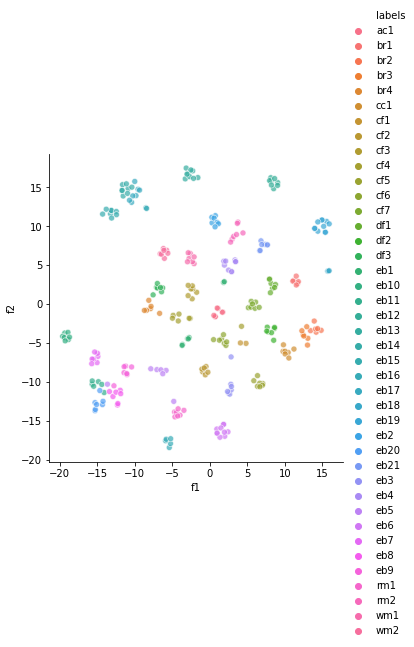

In [20]:
bert_model.train()
bert_model = bert_model.to(device)

for epoch in range(train_from, EMB_EPOCHS):
    running_bert_loss = 0.0

    for data in sTrainLoader:
        feature, labels = data
        
        bert_optimizer.zero_grad()
        
        bert_loss = triplet_loss([feature], labels.to(device)) # forward passing and get loss
        
        bert_loss.backward()
        bert_optimizer.step()
        running_bert_loss += bert_loss.item()
        
    timestamp(f"[epoch {epoch+1}] bert_loss: {running_bert_loss:.3f}")    
    writer.add_scalar('Loss/bert', running_bert_loss, epoch)
    if (epoch+1) % 10 == 0:
            emb_visualize(bert_model, epoch+1)

    if (epoch+1) >= 50 and (epoch+1) % 25 == 0:
        bert_model.save(f"{MODEL_PATH}_bert_E_{epoch+1}.pt")

In [21]:
timestamp(f"start training {MODEL_PATH} from epoch {train_from+1} to {CLS_EPOCHS}")
for epoch in range(train_from, CLS_EPOCHS):
    running_cls_loss = 0.0

    for data in (trainLoader):
        tokens_tensors, segments_tensors, masks_tensors, \
        labels = [t.to(device) for t in data if torch.is_tensor(t)]
        
        # 將參數梯度歸零
        cls_optimizer.zero_grad()
        
        # forward pass
        resize = labels.view(-1).shape[0]
        emb = bert_model.encode(data[4], convert_to_tensor=True)
        outputs = cls_model(emb)
        
        loss_fct = nn.CrossEntropyLoss()
        cls_loss = loss_fct(outputs.intent_cls, labels.view(-1))
        
        # backward
        cls_model.decoder.train()
        bert_model.train()
        cls_loss.backward()
        cls_optimizer.step()
        
        # 紀錄當前 batch loss
        running_cls_loss += cls_loss.item()

    timestamp(f"[epoch {epoch+1}] cls_loss: {running_cls_loss:.3f}")    
    writer.add_scalar('Loss/cls', running_cls_loss, epoch)
    
    _, acc = get_predictions(bert_model, cls_model, trainLoader, compute_acc=True, get_emb=False)
    print(f"[epoch {epoch+1}] training acc: {acc:.6f}")
    writer.add_scalar('Acc/train', acc, epoch)
    
    _, acc = get_predictions(bert_model, cls_model, testLoader, compute_acc=True, get_emb=False)
    print(f"[epoch {epoch+1}] testing acc: {acc:.6f}")
    writer.add_scalar('Acc/test', acc, epoch)

2021-04-01 10:25:05	start training model/tri_base/ckip_vlight_hs from epoch 1 to 20
2021-04-01 10:25:05	[epoch 1] cls_loss: 66.757
[epoch 1] training acc: 0.195804
[epoch 1] testing acc: 0.195804
2021-04-01 10:25:07	[epoch 2] cls_loss: 66.405
[epoch 2] training acc: 0.430070
[epoch 2] testing acc: 0.430070
2021-04-01 10:25:08	[epoch 3] cls_loss: 65.764
[epoch 3] training acc: 0.538462
[epoch 3] testing acc: 0.541958
2021-04-01 10:25:10	[epoch 4] cls_loss: 64.705
[epoch 4] training acc: 0.639860
[epoch 4] testing acc: 0.653846
2021-04-01 10:25:11	[epoch 5] cls_loss: 63.212
[epoch 5] training acc: 0.730769
[epoch 5] testing acc: 0.737762
2021-04-01 10:25:13	[epoch 6] cls_loss: 61.554
[epoch 6] training acc: 0.772727
[epoch 6] testing acc: 0.779720
2021-04-01 10:25:14	[epoch 7] cls_loss: 59.659
[epoch 7] training acc: 0.800699
[epoch 7] testing acc: 0.790210
2021-04-01 10:25:16	[epoch 8] cls_loss: 58.132
[epoch 8] training acc: 0.818182
[epoch 8] testing acc: 0.821678
2021-04-01 10:25:18	

In [24]:
bert_model.save(F"{MODEL_PATH}_bert_E_{EMB_EPOCHS}.pt")
torch.save(cls_model.state_dict(), F"{MODEL_PATH}_cls_E_{CLS_EPOCHS}.pt")

## Visualization

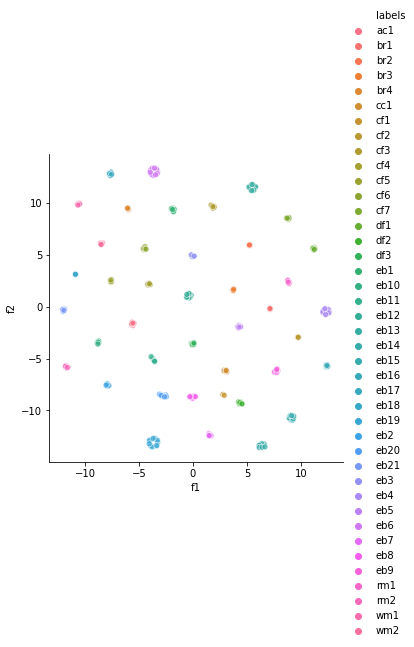

In [23]:
emb_fig = emb_visualize(bert_model, EMB_EPOCHS)

In [28]:
emb_fig.savefig(f"runs/{DATASET}/{MODEL_NAME}/{str(ALPHA).replace('.','')}_{EMB_EPOCHS}/emb.png")
emb_by_cls_fig.savefig(f"runs/{DATASET}/{MODEL_NAME}/{str(ALPHA).replace('.','')}_{EMB_EPOCHS}/emb_bycls.png")

## Test

In [ ]:
testSet = intent_Dataset("test", bert_test)
testLoader = DataLoader(testSet, batch_size=TEST_BATCH_SIZE)

In [ ]:
model = BertForSequenceClassification.from_pretrained(LM, num_labels=num_labels, return_dict=True)

In [ ]:
for e in range(1,9):
    model.load_state_dict(torch.load(f"{MODEL_PATH}_E_{e}.pt"))
    model.eval()
    model = model.to(device)
    _, acc = get_predictions(model, testLoader, compute_acc=True)
    print(f"[epoch {e}] testing acc: {acc:.6f}")

---